## Script to produce Appendix Figure H1 in Carleton et al 2022: 
#### Constructing a hybrid Shared Socioeconomic Scenario (SSP) to approximate an income trajectory that is endogenous to climate change, following Burke, Hsiang, and Miguel (2015)

Panel B shows the mean difference in income between SSP2 and a hybrid socioeconomic scenario in which SSP2 projected income is replaced by SSP3 projected income only for the poorest 60% of countries in 2010. 

Run the notebook sequentially to produce Figure H1. Charts are stored in `OUTPUT/figures/Figure_H1_SSP_compare`


In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

#### Setup

In [122]:
# define paths
REPO = os.getenv('REPO')
DB = os.getenv('DB')
OUTPUT = os.getenv('OUTPUT')

# inputs
gdppath = '{}/2_projection/2_econ_vars'.format(DB)
poppath = '{}/3_valuation/inputs/interpolated_pop_exp'.format(DB)

# output
output_dir = '{}/figures/Figure_H1_SSP_compare'.format(OUTPUT)

In [109]:
# define utility functions

def wquantile(x,q):           
    xsort = x.sort_values(x.columns[0])
    xsort['index'] = range(len(x))
    p = q * x[x.columns[1]].sum()
    pop = float(xsort[xsort.columns[1]][xsort['index']==0])
    i = 0
    while pop < p:
        pop = pop + float(xsort[xsort.columns[1]][xsort['index']==i+1])
        i = i + 1
    return xsort[xsort.columns[0]][xsort['index']==i]

def reset_index(df):
    '''Returns DataFrame with index as columns'''
    index_df = df.index.to_frame(index=False)
    df = df.reset_index(drop=True)
    #  In merge is important the order in which you pass the dataframes
    # if the index contains a Categorical. 
    # pd.merge(df, index_df, left_index=True, right_index=True) does not work
    return pd.merge(index_df, df, left_index=True, right_index=True)

### set parameters and toggles

In [124]:
""" Creates dataframe and chart showing time series of difference in iso-level GDPpc of one
    SSP scenario relative to another of 5 income quintiles divided based on a reference year

    Distinct steps in this process include:
        - identify income quintiles
        - create timeseries of average GDPpc under each scenario
        - take ratio of comparison to reference
        - plot output

Parameters
----------
df1: SSP you are plotting difference of 
df2: reference SSP
flatten: True if setting the top 2 quintiles to 0
year: year which quintile breakdown is based; default is 2010
logvar: False if using GDPpc in $ (default); True if using log GDPpc
savefig: saves to OUTPUT/figures/Figure_H1_SSP_compare

"""

SSPtest = 'SSP3'
SSPref = 'SSP2'
flatten=True 
year=2010
logvar=False
savefig=True

In [112]:
# import data 
df1l = pd.read_csv(os.path.join(gdppath, 'iso_gdppc_low_{}.csv'.format(SSPtest)))
df1h = pd.read_csv(os.path.join(gdppath, 'iso_gdppc_high_{}.csv'.format(SSPtest)))

df2l = pd.read_csv(os.path.join(gdppath, 'iso_gdppc_low_{}.csv'.format(SSPref)))
df2h = pd.read_csv(os.path.join(gdppath, 'iso_gdppc_high_{}.csv'.format(SSPref)))

dfpop1 = xr.open_dataset(os.path.join(poppath, 'interpolated_pop_exp_{}.nc4'.format(SSPtest)))
dfpop2 = xr.open_dataset(os.path.join(poppath, 'interpolated_pop_exp_{}.nc4'.format(SSPref)))

# extract only relevant pop data
dfpop1 = dfpop1.squeeze('ssp').to_dataframe().reset_index()[['iso', 'region', 'year', 'pop']].groupby(['iso', 'year']).sum().reset_index()
dfpop2 = dfpop2.squeeze('ssp').to_dataframe().reset_index()[['iso', 'region', 'year', 'pop']].groupby(['iso', 'year']).sum().reset_index()

In [113]:
# rename gdp cols
df1l.rename(columns={'0':'low_gdp'}, inplace=True)
df1h.rename(columns={'0':'high_gdp'}, inplace=True)
df2l.rename(columns={'0':'low_gdp'}, inplace=True)
df2h.rename(columns={'0':'high_gdp'}, inplace=True)

# combine low and high IAM in each GDP SSP file
df1 = df1l[['iso', 'year', 'low_gdp']].merge(df1h[['iso', 'year', 'high_gdp']], left_on=['iso', 'year'], right_on=['iso', 'year'])
df2 = df2l[['iso', 'year', 'low_gdp']].merge(df2h[['iso', 'year', 'high_gdp']], left_on=['iso', 'year'], right_on=['iso', 'year'])

# create avg gdp per ssp
df1['gdppc'] = (df1['low_gdp'] + df1['high_gdp'])/2
df2['gdppc'] = (df2['low_gdp'] + df2['high_gdp'])/2

In [115]:
# quintiles identified in df1 will equal df2 

# take only 2010 and relevant columns
df_temp = df1.loc[df1['year']==2010, ['iso',"gdppc"]].reset_index(drop=True)

# drop duplicates (which are currently small countries just filled in by global average)
df_temp = df_temp.drop_duplicates(subset=['gdppc']).reset_index(drop=True)

# divide into 5 quintiles
qlabs = ["Poorest 20%", "20-40 Percentile", "Middle 20%", "60-80 Percentile", "Richest 20%"]
df_temp['qtile'] = pd.qcut(df_temp['gdppc'], 5, labels=qlabs)

In [117]:
# merge quintiles into gdp dfs
df1 = df1.merge(df_temp[['iso','qtile']], how='left', left_on='iso', right_on='iso')[['iso', 'year', 'gdppc', 'qtile']]
df2 = df2.merge(df_temp[['iso','qtile']], how='left', left_on='iso', right_on='iso')[['iso', 'year', 'gdppc', 'qtile']]

# merge pop data into gdp dfs
df1 = df1.merge(dfpop1, how='left', left_on=['iso', 'year'], right_on=['iso', 'year'])
df2 = df2.merge(dfpop2, how='left', left_on=['iso', 'year'], right_on=['iso', 'year'])

In [118]:
# calculate population weights by year, qtile 
df1['pweight'] = df1['pop']/df1.groupby(['year','qtile'])['pop'].transform('sum')
df2['pweight'] = df2['pop']/df2.groupby(['year','qtile'])['pop'].transform('sum')

# multiply out gdp by weight
df1['wgdp'] = df1['gdppc'] * df1['pweight']
df2['wgdp'] = df2['gdppc'] * df2['pweight']

# take annual means by quintile
df1 = reset_index(pd.pivot_table(df1, values='wgdp', index='year', columns='qtile', aggfunc='sum'))
df2 = reset_index(pd.pivot_table(df2, values='wgdp', index='year', columns='qtile', aggfunc='sum'))

In [119]:
# calculate ratio between df1/df2
d = {}
for q in qlabs:
    d[q] = (df1[q] / df2[q] - 1)*100

# set highest 2 quintiles to 0 if flatten == true
if flatten == True:
    d["60-80 Percentile"] = d["60-80 Percentile"] * 0
    d["Richest 20%"] = d["Richest 20%"] * 0  

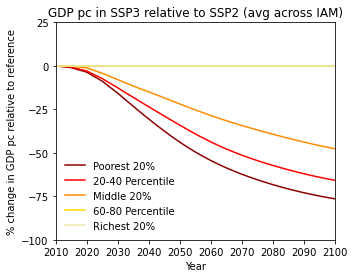

In [126]:
# plot results
years = df1['year']

colors = ['darkred', 'red', 'darkorange', 'gold', 'palegoldenrod']

for i, q in enumerate(qlabs):
    plt.plot(years, d[q], c=colors[i])
plt.xlabel('Year')
plt.ylabel('% change in GDP pc relative to reference')
plt.title(f"GDP pc in {SSPtest} relative to {SSPref} (avg across IAM)")
plt.legend(qlabs, frameon=False, loc="lower left")
plt.hlines(0, min(df1['year']), max(df1['year']), colors='black', linewidth=.6)
plt.ylim([-100, 25])
plt.locator_params(axis="y", nbins=5)
plt.rcParams["figure.figsize"] = (5,4)
plt.margins(0)

if savefig:
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    plt.savefig(os.path.join(output_dir, '{}_income_compare_{}.pdf'.format(SSPtest, SSPref)))
    
plt.show()